# Unique Steady-State Squeezing

In this example we show the unique squeezing observed in a driven Dicke model described by $N$ two-level systems coupled to a quantized harmonic oscillator. First we present the full dynamics with a second order cumulant expansion. The Hamiltonian describing the system is

\begin{align}
H = \omega a^\dagger a + \frac{\Omega}{2} \sum_j  \sigma^j_z + \frac{g}{2} \sum_j  (a^\dagger + a) \sigma^j_x + \eta ( a \, e^{i \omega_\mathrm{d} t} + a^\dagger e^{-i \omega_\mathrm{d} t}),
\end{align}

for $N = 1$ it describes the driven quantum Rabi model. Additionally the system features two decay channels, losses of the harmonic oscillator with rate $\kappa$ and relaxation of the two-level system with rate $\gamma$.

We start by loading the packages.

In [93]:
using QuantumCumulants
using OrdinaryDiffEq, ModelingToolkit
using Plots
nothing # hide

We define the Hilbert space and the symbolic parameters of the system.

In [94]:
# Define hilbert space
hf = FockSpace(:harmonic)
ha = NLevelSpace(Symbol(:spin),2)
h = hf ⊗ ha

# Paramter
@cnumbers ω Ω ωd η κ g γ N 
@syms t::Real # time
nothing # hide

On the Hilbert space we create the destroy operator $a$ of the harmonic oscillator and the (indexed) transition operator $\sigma_i^{xy}$ for the $i$-th two-level system. 

In [95]:
@qnumbers a::Destroy(h)
σ(x,y,i) = IndexedOperator(Transition(h,:σ,x,y),i)
nothing # hide

With the symbolic parameters, operators and indices we define the Hamiltonian and Liouvillian of the system. Note, however, that in the strong coupling regime $g \sim g_c\equiv \sqrt{\omega \Omega}$ the driving term and jump operators have to be redefined. For a strongly interacting system, the ground state is very different from the  ground state of a non-interacting system. Therefore, using jump operators of a non-interacting system would lead to extraction of energy from the ground state of a strongly interacting system. It can be argued that the right operators are the ones that diagonlize the Hamiltonian (see https://arxiv.org/abs/2305.14290 for details).

In [96]:
# Operators diagonalizing the Hamiltonian
ξ = 1/4*log(1-N*g^2/(ω*Ω)) # additional parameter
b = a*cosh(ξ) + a'*sinh(ξ) # approximate new eigenmodes of the system
#b = a

# Indices
i = Index(h,:i,N,ha)
j = Index(h,:j,N,ha)

# Hamiltonian
Hf =  ω*a'*a + η*(b'*exp(-1im*ωd*t) + b*exp(1im*ωd*t) )
Ha =  Ω*Σ(σ(2,2,i)-σ(1,1,i),i)/2
Hi =  g*Σ((σ(1,2,i)+σ(2,1,i))*(a + a'),i)/2
H = Hf + Ha + Hi

# Jump operators & and rates
J = [b, σ(1,2,i)]
rates = [κ, γ]

nothing # hide

First we derive the mean-field equations in second order for $\langle a \rangle$, $\langle a^\dagger a \rangle$ and $\langle \sigma^{22}_j \rangle$, then we complete the system to obtain a closed set of equations.

In [97]:
eqs = meanfield([a, a'a, σ(2,2,j)],H,J;rates=rates,order=2)
nothing # hide

In [98]:
eqs_c = complete(eqs)
length(eqs_c)

13

All two-level systems behave identically, due to this permutation symmetry of the system we can scale-up the equations.

In [99]:
eqs_sc = scale(eqs_c)
scale(eqs) # Example scaling on the first three equations
nothing # hide

To calculate the dynamics of the system we create a system of ordinary differential equations with its initial state and numerical parameters.

In [100]:
# symbolic ordinary differential equation system
@named sys = ODESystem(eqs_sc)

# initial state 
u0 = zeros(ComplexF64, length(eqs_sc));

# Parameters
ω_ = 1.0
Ω_ = 2e3ω_
gc_ = sqrt(Ω_*ω_/N) # renormalization of coupling to keep the system intensive
g_ = 0.9gc_
η_ = 4ω_
κ_ = ω_
γ_ = ω_
ωd_ = sqrt(1-g_^2/gc_^2)*ω_

nothing # hide

We solve the dynamics for four different numbers of two-level systems $N = [1, 2, 10, 100]$.

In [120]:
sol_ls = []
N_ls = [1,2,10,100]
for N_ in N_ls
    p0 = [ω_, Ω_, ωd_, g_, η_, κ_, γ_, N_]
    prob = ODEProblem(sys,u0,(0.0, 4π/ωd_), ps.=>p0)
    sol = solve(prob,Tsit5(); saveat=π/30ωd_ ,reltol=1e-10,abstol=1e-10)
    push!(sol_ls,sol)
end

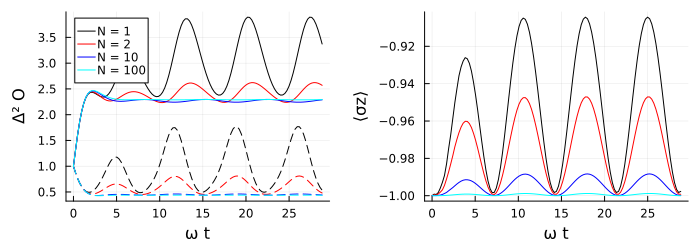

In [121]:
# plot results
c_ls=[:black, :red, :blue, :cyan]
p1 = plot(xlabel="ω t", ylabel="Δ² O")
p2 = plot(xlabel="ω t", ylabel="⟨σz⟩")
for i=1:length(N_ls)
    sol = sol_ls[i]
    t_ = sol.t
    
    sqx = sol[a'*a'] + sol[a*a] + 2*sol[a'*a] .+ 1 - (sol[a'] + sol[a]).^2
    sqy = sol[a'*a'] + sol[a*a] - 2*sol[a'*a] .- 1 - (sol[a'] - sol[a]).^2
    plot!(p1,t_,real.(sqx),label="N = $(N_ls[i])",color=c_ls[i]) 
    plot!(p1,t_,-real.(sqy),ls=:dash,label=nothing,color=c_ls[i])

    s22 = sol[σ(2,2,1)] 
    plot!(p2,t_,real.(2s22 .- 1),color=c_ls[i],label=nothing)
end
plot(p1, p2, layout=(1,2), size=(700,250),bottom_margin=5*Plots.mm, left_margin=5*Plots.mm)

## Effective model

For a suffeciently low excitation we can adiabatically elminate the dynamics of the two-level system(s). This leads to an effective Hamiltonian 

\begin{align}
H_\mathrm{a} = \omega a^\dagger a - \frac{g^2}{4 \Omega}(a + a^\dagger)^2 + \eta ( a \, e^{i \omega_\mathrm{d} t} + a^\dagger e^{-i \omega_\mathrm{d} t}).
\end{align}

We calculate now the dynamics for this effective model and compare it with the full system. Note that this Hamiltonian is quadratic, which means that a second order description is exact. 

In [122]:
# effective Hamiltonian
@cnumbers gΩ # g^2/4Ω
H_a = Hf - N*g^2/(4*Ω*ω)*(a + a')^2 # N is added for the sake of intesitivity

eqs_a = meanfield([a, a'a, a*a],H_a,[b];rates=[κ],order=2)
nothing # hide

In [123]:
# symbolic ordinary differential equation system
@named sys_a = ODESystem(eqs_a)

# initial state 
u0_a = zeros(ComplexF64, length(eqs_a))

# Additional parameter
gΩ_ = g_^2/(4Ω_)
N_ = 69 # the final result does not depend on N

# symbolic and numeric parameter list
ps_a = [ω , ωd , η , κ , N , g , Ω ]
p0_a = [ω_, ωd_, η_, κ_, N_, g_, Ω_]

# define and solve numeric ordinary differential equation problem
prob_a = ODEProblem(sys_a,u0_a,(0.0, 4π/ωd_), ps_a.=>p0_a)
sol_a = solve(prob_a,Tsit5(); saveat=π/30ωd_, reltol=1e-8,abstol=1e-8)
nothing # hide

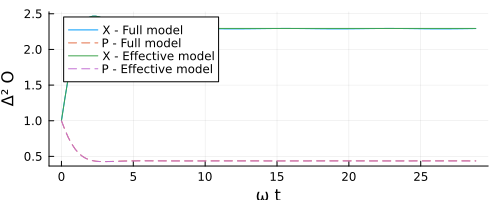

In [124]:
# plot results
sol = sol_ls[4]
t_ = sol.t
sqx = sol[a'*a'] + sol[a*a] + 2*sol[a'*a] .+ 1 - (sol[a'] + sol[a]).^2
sqy = sol[a'*a'] + sol[a*a] - 2*sol[a'*a] .- 1 - (sol[a'] - sol[a]).^2

t_a = sol_a.t
sqx_a = sol_a[a'*a'] + sol_a[a*a] + 2*sol_a[a'*a] .+ 1 - (sol_a[a'] + sol_a[a]).^2
sqy_a = sol_a[a'*a'] + sol_a[a*a] - 2*sol_a[a'*a] .- 1 - (sol_a[a'] - sol_a[a]).^2

p = plot(xlabel="ω t", ylabel="Δ² O")
plot!(p,t_,real.(sqx),label="X - Full model") 
plot!(p,t_,-real.(sqy),label="P - Full model",ls=:dash)
plot!(p,t_a,real.(sqx_a),label="X - Effective model") 
plot!(p,t_a,-real.(sqy_a),label="P - Effective model",ls=:dash)
plot(p, size=(500,200))